In [1]:
import pandas as pd
import analysis_relabel_funcs
from analysis import read_dfs
import torch
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls results

01:05:10-conv_ai_3-train-eval_sbc.out
01:05:10-conv_ai_3-train-partial-predictions-eval_sbc.out
01:26:28-conv_ai_3-validation-eval_sbc.out
01:26:28-conv_ai_3-validation-partial-predictions-eval_sbc.out
02:05:13-conv_ai_3-train-eval_rtgender.out
02:05:13-conv_ai_3-train-partial-predictions-eval_rtgender.out
02:27:05-conv_ai_3-validation-eval_rtgender.out
02:27:05-conv_ai_3-validation-partial-predictions-eval_rtgender.out
02:32:58-ted_talks_iwslt-train-eval_rtgender.out
02:32:58-ted_talks_iwslt-train-partial-predictions-eval_rtgender.out
02:39:43-ted_talks_iwslt-train-eval_rtgender.out
02:39:43-ted_talks_iwslt-train-partial-predictions-eval_rtgender.out
02:47:59-ted_talks_iwslt-train-eval_sbc.out
02:47:59-ted_talks_iwslt-train-partial-predictions-eval_sbc.out
02:54:48-ted_talks_iwslt-train-eval_sbc.out
02:54:48-ted_talks_iwslt-train-partial-predictions-eval_sbc.out


In [3]:
# for using sbc and rt_gender for conv_ai
sbc_conv, rt_gender_conv, sbc_rt_conv = read_dfs("results/01:05:10-conv_ai_3-train-eval_sbc.out", 
                                                "results/02:05:13-conv_ai_3-train-eval_rtgender.out",
                                                suffixes=('_sbf', '_rt'))

In [4]:
sbc_rt_conv[["sentence", "predictions_sbf", "predictions_rt"]].head()

,sentence,predictions_sbf,predictions_rt
0,yes am interested in obamas family,"[tensor(1.0437), tensor(-0.6024), tensor(0.1484)]","[tensor(-0.6332), tensor(0.6919), tensor(-0.84..."
1,yes i want to know who made up his family,"[tensor(1.8043), tensor(-0.6631), tensor(-0.11...","[tensor(0.0839), tensor(0.8344), tensor(-0.699..."
2,yes this is what am looking for,"[tensor(2.2968), tensor(-0.6913), tensor(-0.45...","[tensor(0.1760), tensor(1.0104), tensor(-0.106..."
3,no find the barack obamas family tree time mag...,"[tensor(1.2287), tensor(-0.5359), tensor(0.0472)]","[tensor(-0.6308), tensor(0.5328), tensor(-0.92..."
4,no i need the specific time magazine article t...,"[tensor(1.1137), tensor(-0.4908), tensor(0.1666)]","[tensor(-0.0311), tensor(1.0237), tensor(-0.65..."


In [5]:
# for each prediction in predictions_sbc and predictions_rt, 
# return the categorical variable and the score using the relabel_funcs

s = sbc_rt_conv["predictions_sbf"].map(analysis_relabel_funcs.return_social_bias_frames)
s = pd.DataFrame(s.tolist(), columns=["scores_sbf", "category_sbf"])
s["scores_sbf"] = s["scores_sbf"].map(lambda x: x.item()) # comes back as a tensor, change it to float
sbc_rt_conv = sbc_rt_conv.join(s)

# do the same thing, but for rt_gender instead 
s = sbc_rt_conv["predictions_rt"].map(analysis_relabel_funcs.return_rt_gender)
s = pd.DataFrame(s.tolist(), columns=["scores_rt", "category_rt"])
s["scores_rt"] = s["scores_rt"].map(lambda x: x.item()) # comes back as a tensor, change it to float
sbc_rt_conv = sbc_rt_conv.join(s)

In [6]:
sbc_rt_conv.head()

,sentence,predictions_sbf,predictions_rt,scores_sbf,category_sbf,scores_rt,category_rt
0,yes am interested in obamas family,"[tensor(1.0437), tensor(-0.6024), tensor(0.1484)]","[tensor(-0.6332), tensor(0.6919), tensor(-0.84...",-0.369400,Not,-0.016630,Positive
1,yes i want to know who made up his family,"[tensor(1.8043), tensor(-0.6631), tensor(-0.11...","[tensor(0.0839), tensor(0.8344), tensor(-0.699...",-0.691929,Not,-0.106754,Neutral
2,yes this is what am looking for,"[tensor(2.2968), tensor(-0.6913), tensor(-0.45...","[tensor(0.1760), tensor(1.0104), tensor(-0.106...",-0.840425,Not,-0.050733,Neutral
3,no find the barack obamas family tree time mag...,"[tensor(1.2287), tensor(-0.5359), tensor(0.0472)]","[tensor(-0.6308), tensor(0.5328), tensor(-0.92...",-0.468977,Not,-0.022241,Positive
4,no i need the specific time magazine article t...,"[tensor(1.1137), tensor(-0.4908), tensor(0.1666)]","[tensor(-0.0311), tensor(1.0237), tensor(-0.65...",-0.385269,Not,-0.074436,Neutral


In [7]:
# normalize, take the scores of sbf and rt and do a covariance
std_scaler = StandardScaler()
scores_df = sbc_rt_conv[["scores_sbf", "scores_rt"]]
scores_df = pd.DataFrame(std_scaler.fit_transform(scores_df), columns=scores_df.columns)
scores_df.cov()

,scores_sbf,scores_rt
scores_sbf,1.000001,-0.787093
scores_rt,-0.787093,1.000001


In [19]:
# take the categories and do a chi2 test
# first get the contingency table
contingency = pd.crosstab(sbc_rt_conv["category_sbf"], sbc_rt_conv["category_rt"])
c, p, dof, expected = chi2_contingency(contingency)
print(f"p-value is {p}")

p-value is 1.520037777915489e-211


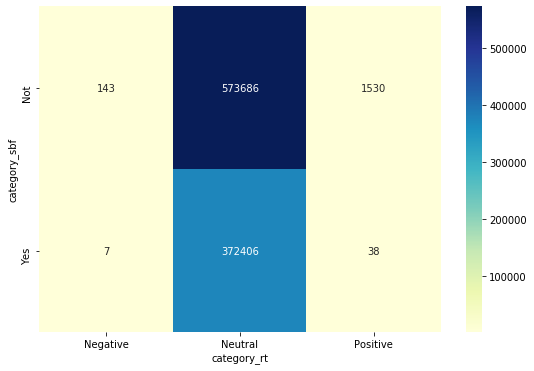

In [21]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(contingency, annot=True, fmt="d", cmap="YlGnBu")